In [1]:
# !pip install openrank-sdk

In [2]:
from google.cloud import bigquery
from openrank_sdk import EigenTrust
import matplotlib
import os
import pandas
import seaborn as sns

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../../../gcp_credentials.json"
client = bigquery.Client()
a = EigenTrust()

In [4]:
seeded_developers_query = """
    with targeted_repos as (
      select
        artifact_id,
        artifact_name
      from `opensource-observer`.`oso`.`int_artifacts_in_ossd_by_project`
      where artifact_url in (
        'https://github.com/ethereum/eips',
        'https://github.com/ethereum/solidity',
        'https://github.com/ethereum/go-ethereum'
      )
    )
    
    select
      a.artifact_name as user,
      targeted_repos.artifact_name as repo,
      e.event_type,
      e.bucket_month,
      e.amount
    from `opensource-observer`.`oso`.`int_events_monthly_to_project` e
    join `opensource-observer`.`oso`.`int_artifacts` a
      on e.from_artifact_id = a.artifact_id
    join targeted_repos
      on e.to_artifact_id = targeted_repos.artifact_id
    where
      e.event_type = 'COMMIT_CODE'
      and e.bucket_month > '2014-01-01'
      and e.bucket_month < '2018-01-01'
      and e.to_artifact_id in (
        select artifact_id
        from targeted_repos
      )
"""
seeded_developers_result = client.query(seeded_developers_query)
seeded_developers = seeded_developers_result.to_dataframe()

In [5]:
# simple illustration of a weighting function
def weight_contributions(bucket_month, amount):
    year = bucket_month.year
    weight = ((2018-year)/4) * (amount ** .5)
    return weight

seeded_developers['v'] = seeded_developers.apply(lambda x: weight_contributions(x['bucket_month'], x['amount']), axis=1)

pretrust = []
developers = []
for (i,v) in seeded_developers.groupby('user')['v'].sum().items():
    pretrust.append({'i': i, 'v': v})
    developers.append(i)

pretrust

[{'i': 'arachnid', 'v': 25.973726397955925},
 {'i': 'arkpar', 'v': 10.242640687119286},
 {'i': 'axic', 'v': 116.61569346521169},
 {'i': 'bobsummerwill', 'v': 47.2411131780082},
 {'i': 'caktux', 'v': 2.0},
 {'i': 'cdetrio', 'v': 18.406911894894584},
 {'i': 'chfast', 'v': 9.388905057061258},
 {'i': 'chriseth', 'v': 494.06758656329856},
 {'i': 'debris', 'v': 10.242640687119286},
 {'i': 'fjl', 'v': 90.72227044612627},
 {'i': 'frozeman', 'v': 2.8284271247461903},
 {'i': 'gavofyork', 'v': 30.60391616456742},
 {'i': 'gcolvin', 'v': 17.939141713692827},
 {'i': 'gustav-simonsson', 'v': 6.708203932499369},
 {'i': 'holiman', 'v': 3.605551275463989},
 {'i': 'karalabe', 'v': 164.97245496855268},
 {'i': 'lefterisjp', 'v': 12.70820393249937},
 {'i': 'lianahus', 'v': 16.071067811865476},
 {'i': 'nicksavers', 'v': 4.449489742783178},
 {'i': 'obscuren', 'v': 249.26646883283263},
 {'i': 'pirapira', 'v': 82.79310427491905},
 {'i': 'souptacular', 'v': 23.739384613047367},
 {'i': 'vbuterin', 'v': 13.0},
 {'

In [6]:
developers_str = "'"+"','".join(developers)+"'"
trusted_repos_query = f"""
    with trusted_repos as (
      select
        e.to_artifact_id as artifact_id,
        users.artifact_name as trusted_user,
        e.event_type as trusted_event
      from `opensource-observer`.`oso`.`int_events_monthly_to_project` e
      join `opensource-observer`.`oso`.`int_artifacts` users
        on e.from_artifact_id = users.artifact_id
      where
        e.event_type in ('STARRED', 'FORKED')
        and e.bucket_month > '2022-01-01'
        and users.artifact_name in ({developers_str})
    )
    
    select
      trusted_repos.trusted_user,
      trusted_repos.trusted_event,
      users.artifact_name as github_user,
      repos.artifact_namespace as github_org,
      repos.artifact_name as github_repo,
      e.event_type,
      e.bucket_month,
      e.amount
    from `opensource-observer`.`oso`.`int_events_monthly_to_project` e
    join `opensource-observer`.`oso`.`int_artifacts` users
      on e.from_artifact_id = users.artifact_id
    join trusted_repos
      on e.to_artifact_id = trusted_repos.artifact_id
    join `opensource-observer`.`oso`.`int_artifacts` repos
      on e.to_artifact_id = repos.artifact_id
    where
      e.event_type = 'COMMIT_CODE'
      and e.bucket_month > '2022-01-01'
"""
trusted_repos_result = client.query(trusted_repos_query)
trusted_repos = trusted_repos_result.to_dataframe()

In [7]:
# another simple illustration of a weighting function
def weight_events(event_type, amount):
    weight = (amount ** .5) * (0.5 if event_type == 'STARRED' else 1.0)
    return weight

trusted_repos['v'] = trusted_repos.apply(lambda x: weight_events(x['event_type'], x['amount']), axis=1)

localtrust = []
for ((i,j),v) in trusted_repos.groupby(['trusted_user', 'github_user'])['v'].sum().items():
    if i == j or '[bot]' in j:
        continue
    localtrust.append({'i': i, 'j': j, 'v': v})

localtrust[:10]

[{'i': 'arachnid', 'j': 'corwintines', 'v': 1593.5519593516221},
 {'i': 'arachnid', 'j': 'ethereumkev', 'v': 1.0},
 {'i': 'arachnid', 'j': 'fredriksvantes', 'v': 5.656854249492381},
 {'i': 'arachnid', 'j': 'futurealisha', 'v': 3.1622776601683795},
 {'i': 'arachnid', 'j': 'jefflau', 'v': 1.0},
 {'i': 'arachnid', 'j': 'jmcook1186', 'v': 194.57573208323848},
 {'i': 'arachnid', 'j': 'lucemans', 'v': 1.0},
 {'i': 'arachnid', 'j': 'minimalsm', 'v': 1224.8160102453955},
 {'i': 'arachnid', 'j': 'nhsz', 'v': 319.713875323741},
 {'i': 'arachnid', 'j': 'pettinarip', 'v': 990.9040706978625}]

In [8]:
pretrust_updated = [x for x in pretrust if x['i'] in trusted_repos['trusted_user'].unique()]
dev_rank = a.run_eigentrust(localtrust, pretrust_updated)
dev_rank[:10]

INFO:root:eigentrust compute took 0.47116562502924353 secs 


[{'i': 'chriseth', 'v': 0.30245385210520304},
 {'i': 'karalabe', 'v': 0.1009913539229886},
 {'i': 'axic', 'v': 0.07141399854121487},
 {'i': 'fjl', 'v': 0.055537543677023744},
 {'i': 'jbaylina', 'v': 0.04085977262845396},
 {'i': 'wanderer', 'v': 0.03896399248674197},
 {'i': 'arachnid', 'v': 0.030439648935354422},
 {'i': 'bobsummerwill', 'v': 0.028919639836757185},
 {'i': 'kasey', 'v': 0.02868871713936498},
 {'i': 'leonmanrolls', 'v': 0.025056751109208016}]

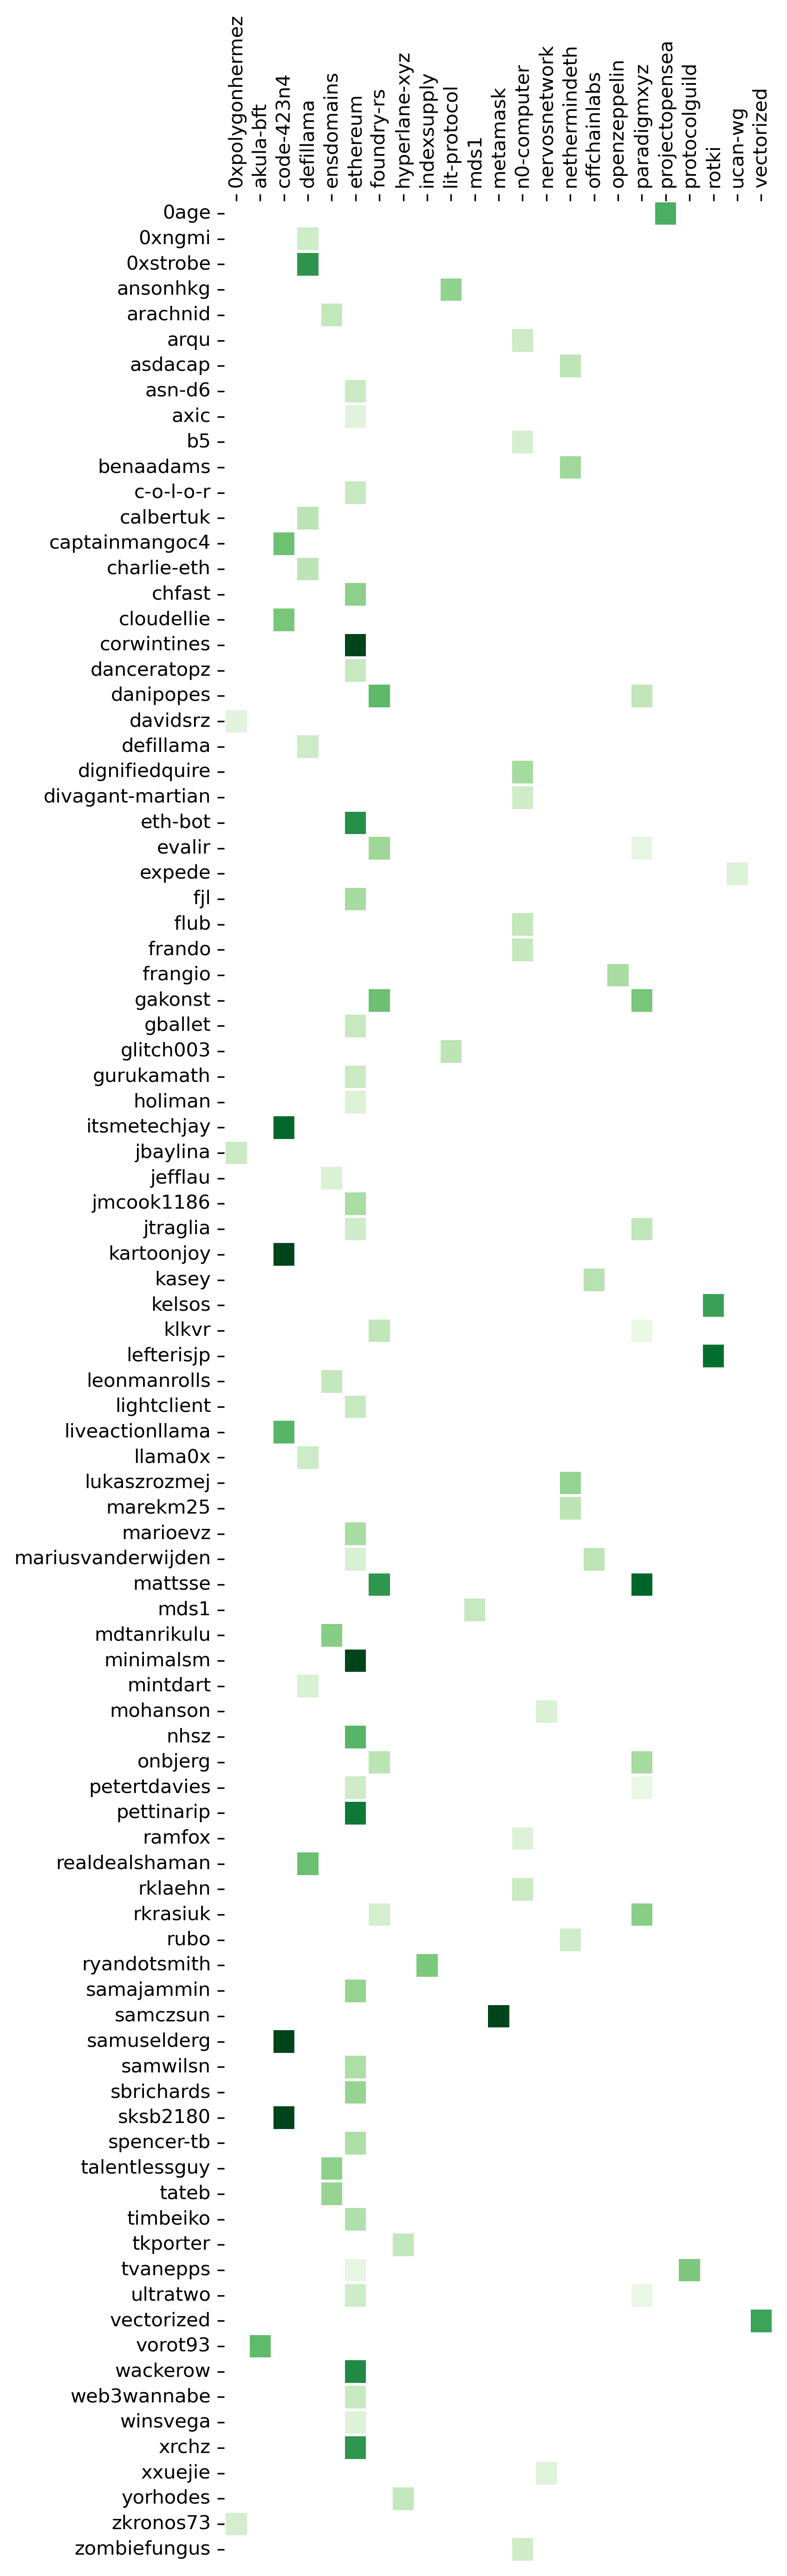

In [9]:
N = 100
devs = [x['i'] for x in dev_rank[:N]]
pvt = (
    trusted_repos[trusted_repos['github_user'].isin(devs)]
    .pivot_table(
        index='github_user',
        columns='github_org',
        values='v'
    )
)

matplotlib.rcParams.update({'font.size': 10})
fig, ax = matplotlib.pyplot.subplots(
    figsize=(pvt.shape[1]/4, pvt.shape[0]/5),
    dpi=300,
    facecolor='white'
)
sns.heatmap(
    data=pvt,
    cmap='Greens', 
    vmin=0, 
    vmax=10, 
    linewidths=1,
    cbar=False, 
    ax=ax
)
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel("")
ax.set_ylabel("")
fig.tight_layout()